In [ ]:
! pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 10.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D, Bidirectional, Flatten
import matplotlib.pyplot as plt
from datasets import load_dataset
import pandas as pd
import gensim
from gensim.models import Word2Vec
from keras.utils import pad_sequences


In [ ]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [ ]:
dataset = load_dataset("ag_news")
df_test = pd.DataFrame(dataset['test'])
df_train = pd.DataFrame(dataset['train'])
df_train = df_train.groupby('label').apply(lambda x: x.sample(n=4000)).reset_index(drop=True)
df_train = pd.concat([df_train, df_test], axis=0)

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Dataset ag_news downloaded and prepared to /root/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
df_train # 16000+7600

,text,label
0,Baghdad hit by several bomb blasts A suicide b...,0
1,"US revises its strategy on Sudan, seeks UN aid...",0
2,Rebels in Nepal Kill Policeman as the Capital ...,0
3,Goss Quote Box (AP) AP - Quotes from Rep. Port...,0
4,Netanyahu to PM: I #39;ll stay in gov #39;t Fi...,0
...,...,...
7595,Around the world Ukrainian presidential candid...,0
7596,Void is filled with Clement With the supply of...,1
7597,Martinez leaves bitter Like Roger Clemens did ...,1
7598,5 of arthritis patients in Singapore take Bext...,2


In [ ]:
df_train.label.value_counts()

0    5900
1    5900
2    5900
3    5900
Name: label, dtype: int64

In [ ]:
df_test.label.value_counts()

2    1900
3    1900
1    1900
0    1900
Name: label, dtype: int64

In [ ]:
df_train.shape

(23600, 2)

In [ ]:
from keras.utils import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from sklearn.model_selection import train_test_split


In [ ]:
tokenizer = text.Tokenizer(num_words=20000)  # limit to the num_words most important ones
tokenizer.fit_on_texts(list(df_train['text']))
tokenized_texts = tokenizer.texts_to_sequences(df_train['text'])
X = pad_sequences(tokenized_texts, maxlen=100)
y = pd.get_dummies(df_train["label"]).values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.32, random_state=42)

In [ ]:
import os
import tqdm
import requests
import zipfile
URL = "http://nlp.stanford.edu/data/glove.42B.300d.zip"
# https://nlp.stanford.edu/projects/glove/
# https://github.com/stanfordnlp/GloVe


def fetch_data(url=URL, target_file='glove.zip', delete_zip=False):
    #if the dataset already exists exit
    if os.path.isfile(target_file):
        print("datasets already downloded :) ")
        return

    #download (large) zip file
    #for large https request on stream mode to avoid out of memory issues
    #see : http://masnun.com/2016/09/18/python-using-the-requests-module-to-download-large-files-efficiently.html
    print("**************************")
    print("  Downloading zip file")
    print("  >_<  Please wait >_< ")
    print("**************************")
    response = requests.get(url, stream=True)
    #read chunk by chunk
    handle = open(target_file, "wb")
    for chunk in tqdm.tqdm(response.iter_content(chunk_size=512)):
        if chunk:  
            handle.write(chunk)
    handle.close()  
    print("  Download completed ;) :") 
    #extract zip_file
    zf = zipfile.ZipFile(target_file)
    print("1. Extracting {} file".format(target_file))
    zf.extractall()
    if delete_zip:
        print("2. Deleting {} file".format(dataset_name+".zip"))
        os.remove(path=zip_file)

fetch_data()

**************************
  >_<  Please wait >_< 
**************************


3667580it [05:52, 10405.53it/s]


  Download completed ;) :
1. Extracting glove.zip file


In [ ]:
glove_file = "glove.42B.300d.txt"
import tqdm

EMBEDDING_VECTOR_LENGTH = 100 # <=200
def construct_embedding_matrix(glove_file, word_index):
    embedding_dict = {}
    with open(glove_file,'r') as f:
        for line in f:
            values=line.split()
            # get the word
            word=values[0]
            if word in word_index.keys():
                # get the vector
                vector = np.asarray(values[1:], 'float32')
                embedding_dict[word] = vector
    ###  oov words (out of vacabulary words) will be mapped to 0 vectors

    num_words=len(word_index)+1
    #initialize it to 0
    embedding_matrix=np.zeros((num_words, EMBEDDING_VECTOR_LENGTH))

    for word,i in tqdm.tqdm(word_index.items()):
        if i < num_words:
            vect=embedding_dict.get(word, [])
            if len(vect)>0:
                embedding_matrix[i] = vect[:EMBEDDING_VECTOR_LENGTH]
    return embedding_matrix
  
embedding_matrix =  construct_embedding_matrix(glove_file, tokenizer.word_index)

100%|██████████| 37299/37299 [00:00<00:00, 424768.04it/s]


In [ ]:
from tensorflow.keras.layers import GRU

model = Sequential()
model.add(Embedding(input_dim=len(embedding_matrix), output_dim=100, weights=[embedding_matrix]))
model.add(LSTM(25, return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dense(4, activation='softmax'))  
adam = optimizers.Adam(learning_rate = 0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy']) 

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         3730000   
                                                                 
 lstm (LSTM)                 (None, None, 25)          12600     
                                                                 
 global_max_pooling1d (Globa  (None, 25)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 25)                0         
                                                                 
 dense (Dense)               (None, 50)                1300      
                                                                 
 dense_1 (Dense)             (None, 4)                 204       
                                                        

In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.1)

Epoch 1/10
226/226 [==============================] - 9s 9ms/step - loss: 0.7389 - accuracy: 0.7358 - val_loss: 0.3519 - val_accuracy: 0.8766
Epoch 2/10
226/226 [==============================] - 2s 7ms/step - loss: 0.3227 - accuracy: 0.8984 - val_loss: 0.3174 - val_accuracy: 0.8953
Epoch 3/10
226/226 [==============================] - 2s 7ms/step - loss: 0.2284 - accuracy: 0.9322 - val_loss: 0.3176 - val_accuracy: 0.9028
Epoch 4/10
226/226 [==============================] - 2s 7ms/step - loss: 0.1754 - accuracy: 0.9503 - val_loss: 0.3291 - val_accuracy: 0.9022
Epoch 5/10
226/226 [==============================] - 2s 7ms/step - loss: 0.1341 - accuracy: 0.9639 - val_loss: 0.3749 - val_accuracy: 0.8879
Epoch 6/10
226/226 [==============================] - 2s 7ms/step - loss: 0.1017 - accuracy: 0.9740 - val_loss: 0.3710 - val_accuracy: 0.8903
Epoch 7/10
226/226 [==============================] - 2s 7ms/step - loss: 0.0808 - accuracy: 0.9813 - val_loss: 0.4197 - val_accuracy: 0.8879
Epoch 

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
y_proba = model.predict(X_test)
#print(y_proba)
y_pred = np.argmax(y_proba, axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true=y_true, y_pred=y_pred))
print(confusion_matrix(y_true, y_pred))

236/236 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.85      0.88      0.87      1898
           1       0.95      0.97      0.96      1859
           2       0.87      0.81      0.84      1905
           3       0.85      0.86      0.86      1890

    accuracy                           0.88      7552
   macro avg       0.88      0.88      0.88      7552
weighted avg       0.88      0.88      0.88      7552

[[1678   59  100   61]
 [  45 1800    6    8]
 [ 121   28 1546  210]
 [ 120   16  130 1624]]


In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score
precision, recall, fscore, support= score(y_true, y_pred)
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("F1 score: {}".format(fscore))
print("Support: {}".format(support))
print("Accuracy score:{}".format(accuracy_score(y_true, y_pred)))

Precision: [0.85437882 0.94587493 0.86756453 0.85338939]
Recall: [0.88408851 0.96826251 0.81154856 0.85925926]
F1 score: [0.8689798  0.9569378  0.83862219 0.85631426]
Support: [1898 1859 1905 1890]
Accuracy score:0.8802966101694916


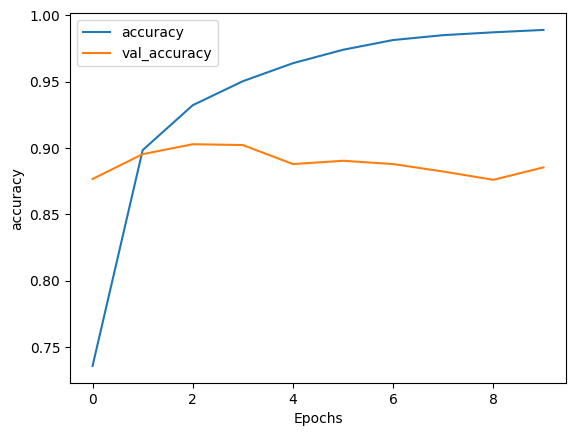

In [ ]:
import matplotlib.pyplot as plt
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
plot_graphs(history, "accuracy")